# 🏍️ European Motorbike Price Prediction Project

## 📌 Project Overview

Welcome to the **European Motorbike Price Prediction Project**! 🚀
Predicting motorbike prices using messy real-world data from European listings. This project tackles data cleaning challenges, explores key price drivers, and builds ML models to accurately predict motorbike values.

## 📊 Dataset Description

* **Source**: European motorbike listings 🌍
* **Features**: make\_model, price, mileage, power, fuel type, gear type, and offer type ⚙️
* **Target Variable**: `price` 💰


## 📋 Table of Contents  

1. [Data-Setup  🗂️](#data-setup)  
2. [Data cleaning/preprocessing🧹](#cleaning)  
3. [Exploratory Data Analysis 🔍 ](#eda)  
4. [Feature Engineering 🎯](#features)  
5. [Model Building 🏗️](#modeling)  
6. [Evaluation 📊](#evaluation)  
7. [Insights 💡](#insights)  




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb as db
from datetime import datetime
import warnings
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import catboost as cb
import shap as sp
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.metrics import mean_absolute_error,r2_score

c:\Users\RAM MOHAN\Machine_learning\Europen_bikes\bike\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data-Setup  🗂️

In [2]:
bike=pd.read_csv('europe-motorbikes-zenrows.csv')
bike.head()

,price,mileage,power,make_model,date,fuel,gear,offer_type,version,link
0,23990,150,218.0,Honda,03/2020,Gasoline,Manual,Demonstration,CBR1000RR-R Fireblade SP,/offers/honda-others-cbr1000rr-r-fireblade-sp-...
1,7500,2871,90.0,BMW F 800 GT,09/2018,Gasoline,Manual,Used,NaN,/offers/bmw-f-800-gt-gasoline-white-f65273c6-6...
2,800,1700,3.0,Nova Motors Retro Star,10/2019,Gasoline,NaN,Used,NaN,/offers/nova-motors-retro-star-gasoline-red-f8...
3,14990,24345,NaN,Aprilia RSV4,03/2016,Gasoline,NaN,Used,RF,/offers/aprilia-rsv4-rf-gasoline-silver-1b51fe...
4,6200,25000,128.0,Kawasaki Ninja ZX-6R,08/2009,Gasoline,NaN,Used,NaN,/offers/kawasaki-ninja-zx-6r-gasoline-blue-2f8...


In [3]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34917 entries, 0 to 34916
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       34917 non-null  int64  
 1   mileage     34917 non-null  int64  
 2   power       28598 non-null  float64
 3   make_model  34917 non-null  object 
 4   date        34917 non-null  object 
 5   fuel        31727 non-null  object 
 6   gear        12847 non-null  object 
 7   offer_type  34917 non-null  object 
 8   version     17413 non-null  object 
 9   link        34917 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 2.7+ MB


In [4]:
bike.isna().sum()

price             0
mileage           0
power          6319
make_model        0
date              0
fuel           3190
gear          22070
offer_type        0
version       17504
link              0
dtype: int64

In [5]:
bike.duplicated().sum()


np.int64(5832)

In [6]:
motor_bike=bike.copy()
motor_bike.drop_duplicates(keep='first',inplace=True)
motor_bike.duplicated().sum()
print(f"Shape after removing duplicates: {motor_bike.shape}")
print(f"Duplicates remaining: {motor_bike.duplicated().sum()}")

Shape after removing duplicates: (29085, 10)
Duplicates remaining: 0


In [7]:
motor_bike.describe()

,price,mileage,power
count,2.908500e+04,2.908500e+04,23681.000000
mean,5.260024e+04,2.237061e+04,143.548921
std,5.314170e+06,2.254719e+05,5954.952080
min,1.000000e+00,0.000000e+00,1.000000
25%,6.500000e+03,2.605000e+03,46.000000
50%,9.000000e+03,1.058200e+04,86.000000
75%,1.338000e+04,2.447000e+04,125.000000
max,8.888889e+08,9.999999e+06,913595.000000


## Data cleaning/preprocessing🧹

To deal with missing values, we used **Simple Imputer**. ✨
It replaces empty or null entries with basic strategies like:

* **Mean / Median** for numerical columns ➗
* **Most Frequent / Constant** for categorical columns 🔤

This ensures our dataset stays complete and ready for analysis without losing important records. ✅


In [8]:

num_cols=['power']
cat_cols=['fuel','gear','version']

In [9]:
num_imputer=SimpleImputer(strategy='median')
cat_imputer=SimpleImputer(strategy='constant',fill_value='Unknown')
motor_bike[num_cols]=num_imputer.fit_transform(motor_bike[num_cols])
motor_bike[cat_cols]=cat_imputer.fit_transform(motor_bike[cat_cols])
motor_bike[cat_cols].head()

,fuel,gear,version
0,Gasoline,Manual,CBR1000RR-R Fireblade SP
1,Gasoline,Manual,Unknown
2,Gasoline,Unknown,Unknown
3,Gasoline,Unknown,RF
4,Gasoline,Unknown,Unknown


In [10]:
motor_bike['date'] = pd.to_datetime(motor_bike['date'], errors='coerce')


C:\Users\RAM MOHAN\AppData\Local\Temp\ipykernel_28860\2222280998.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  motor_bike['date'] = pd.to_datetime(motor_bike['date'], errors='coerce')


In [11]:
motor_bike.describe()

,price,mileage,power,date
count,2.908500e+04,2.908500e+04,29085.000000,29057
mean,5.260024e+04,2.237061e+04,132.856318,2013-10-02 02:56:55.273427968
min,1.000000e+00,0.000000e+00,1.000000,1907-06-01 00:00:00
25%,6.500000e+03,2.605000e+03,54.000000,2012-03-01 00:00:00
50%,9.000000e+03,1.058200e+04,86.000000,2016-06-01 00:00:00
75%,1.338000e+04,2.447000e+04,114.000000,2019-05-01 00:00:00
max,8.888889e+08,9.999999e+06,913595.000000,2022-01-01 00:00:00
std,5.314170e+06,2.254719e+05,5373.358542,NaN


In [12]:
res=db.query(""" select make_model,price,mileage,count(*) as cnt
             from bike 
             group by make_model,price,mileage
             having count(*)>1""").to_df()
res.head()

,make_model,price,mileage,cnt
0,Honda CRF 100,12500,20000,3
1,Suzuki V-Strom 1050,15499,0,18
2,Yamaha XVS 1300,10995,7975,2
3,BMW F 850 GS,12000,1900,2
4,Suzuki Katana 1000,11990,610,2


In [13]:
price_com=db.query("""
select make_model,mileage,count(distinct price),min(price) as min_price,max(price) as max_price from bike 
    group by make_model,mileage
    having count(distinct price)>1""").to_df()
price_com.head()

,make_model,mileage,count(DISTINCT price),min_price,max_price
0,Kawasaki W 800,0,7,8990,11499
1,BMW S 1000 RR,27000,3,8800,12449
2,Harley-Davidson V-Rod,13000,2,16000,24000
3,BMW S 1000 RR,16500,3,9000,14000
4,Suzuki GSX-R 1000,1,3,14900,22899


## Exploratory Data Analysis 🔍

In this stage, we explored the dataset to uncover insights and patterns. 📊
Key steps included:

* Checking **distributions** of numerical features like price, mileage, and power 📈
* Comparing **categorical variables** such as fuel type, gear type, and make\_model 🏷️
* Creating **correlation heatmaps** to see relationships between features 🔗
* Spotting **outliers** that could impact predictions ⚠️

EDA helped us understand the data better and guided feature engineering and model choices. 🚀


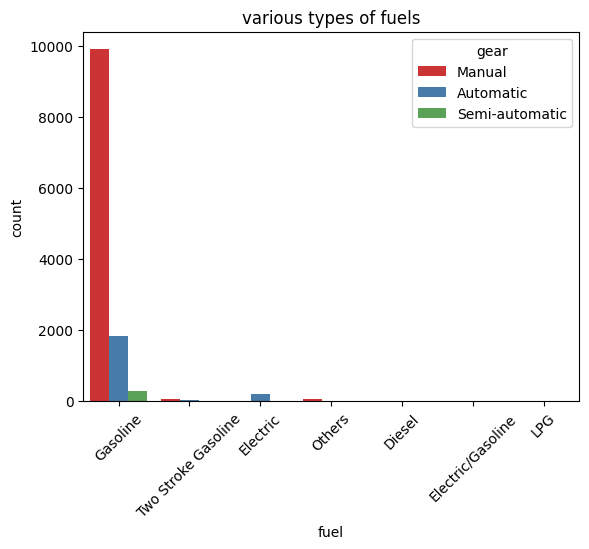

In [14]:
fuels=bike['fuel'].value_counts()
sns.countplot(x='fuel',data=bike,palette='Set1',hue='gear')
plt.title('various types of fuels')
plt.xticks(rotation=45)
plt.show()

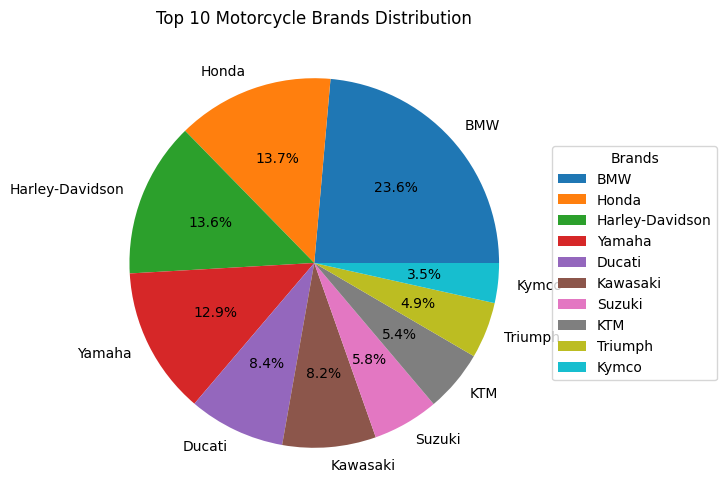

In [15]:
# Get the brand counts
brand_counts = motor_bike['make_model'].apply(lambda x: x.split()[0]).value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(brand_counts.values[:10], 
        labels=brand_counts.index[:10],
        autopct='%1.1f%%')

plt.title('Top 10 Motorcycle Brands Distribution')
plt.legend(title='Brands', 
          loc='center left', 
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

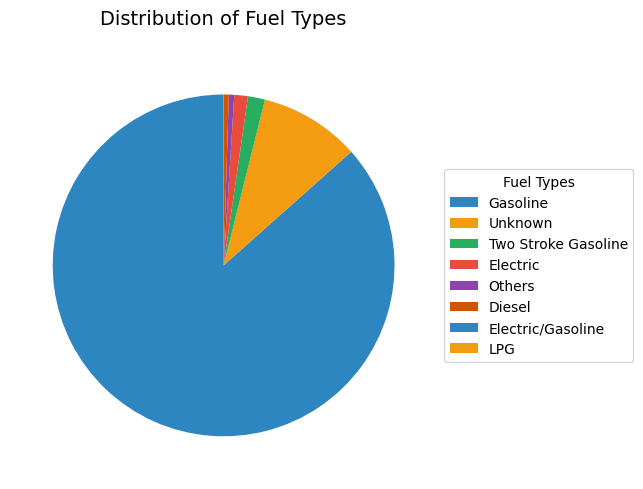

In [16]:
# Get the fuel type counts
fuel_counts = motor_bike['fuel'].value_counts()

# Create pie chart with only colors (no labels, no percentages)
plt.figure(figsize=(8, 5))
plt.pie(fuel_counts.values, 
        colors=['#2E86C1', '#F39C12', '#27AE60', '#E74C3C', '#8E44AD', '#D35400'],
        startangle=90)

plt.title('Distribution of Fuel Types', pad=20, fontsize=14)

# Add legend to the right
plt.legend(fuel_counts.index, title='Fuel Types',
           loc='center left',
           bbox_to_anchor=(1, 0, 0.5, 1))

# Ensure the plot is not cutoff
plt.tight_layout()
plt.show()


## ⚠️ Handling Outliers

Outliers can distort our analysis and model performance. To fix this, we applied the **Capping Method** ✂️:

* Values above the **99th percentile** were capped at that threshold 📏
* Values below the **1st percentile** were capped at that threshold 📉

By capping extreme values at the 1st and 99th percentiles, we controlled outliers while keeping the overall data distribution intact. ✅



--- Top 10 Power Values (Before Capping) ---
6570     913595.0
4938      34596.0
14536     23331.0
29248     12522.0
10091     12447.0
9024      12447.0
4480      12154.0
33834     11971.0
24844     11971.0
22771     11822.0
Name: power, dtype: float64

99th percentile (our new cap) for power is: 228.00

Capping complete. A new column 'power_capped' has been created.


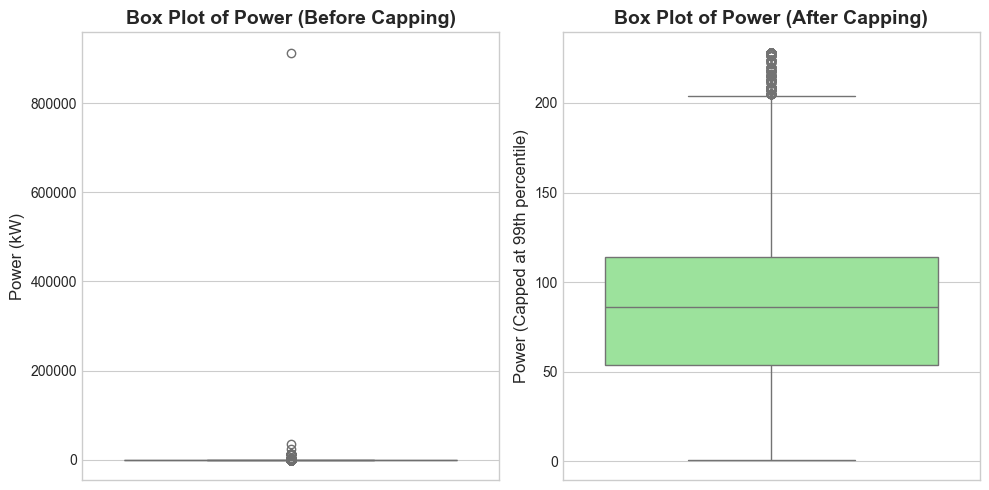

In [17]:
print("\n--- Top 10 Power Values (Before Capping) ---")
print(motor_bike['power'].sort_values(ascending=False).head(10))

# Calculate the 99th percentile to determine the cap
power_cap = motor_bike['power'].quantile(0.99)
print(f"\n99th percentile (our new cap) for power is: {power_cap:.2f}")

# Use the clip() function to cap the outliers
motor_bike['power_capped'] = motor_bike['power'].clip(upper=power_cap)

print("\nCapping complete. A new column 'power_capped' has been created.")


# --- 4. Visualization ---
# Set a nice style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10,5))

# Box plot before capping
plt.subplot(1, 2, 1)
sns.boxplot(y=motor_bike['power'], color='skyblue')
plt.title('Box Plot of Power (Before Capping)', fontsize=14, fontweight='bold')
plt.ylabel('Power (kW)', fontsize=12)

# Box plot after capping
plt.subplot(1, 2, 2)
sns.boxplot(y=motor_bike['power_capped'], color='lightgreen')
plt.title('Box Plot of Power (After Capping)', fontsize=14, fontweight='bold')
plt.ylabel('Power (Capped at 99th percentile)', fontsize=12)

# Display the plots
plt.tight_layout()
plt.show()

--- Top 10 mileage Values (Before Capping) ---
32668    9999999
23281    9999999
28952    9999999
13691    9999999
25011    9999999
33610    9999999
22383    9999999
8875     9999999
4996     9999999
27266    9999999
Name: mileage, dtype: int64

99th percentile (our new cap) for mileage is: 90000.00

Capping complete. A new column 'mileage_capped' has been created.


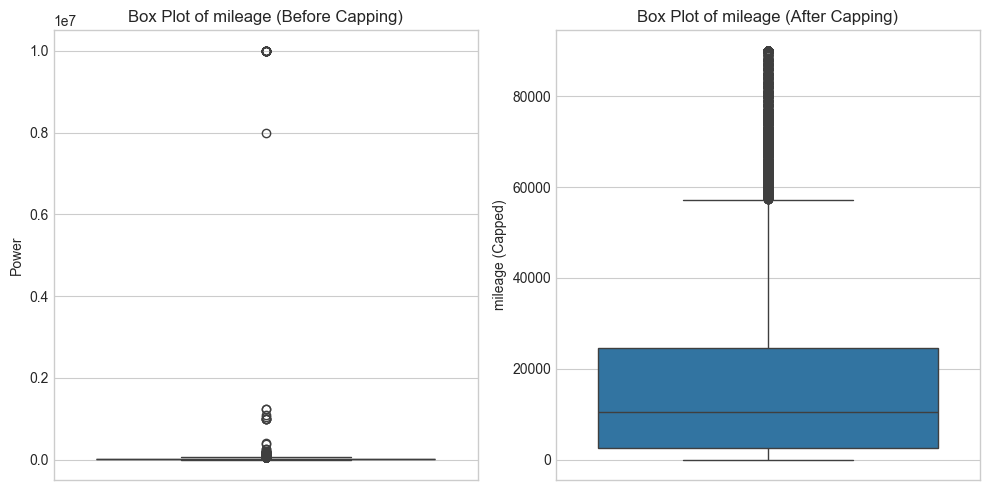

In [18]:
print("--- Top 10 mileage Values (Before Capping) ---")
print(motor_bike['mileage'].sort_values(ascending=False).head(10))
mileage_cap = motor_bike['mileage'].quantile(0.99)
print(f"\n99th percentile (our new cap) for mileage is: {mileage_cap:.2f}")
motor_bike['mileage_capped'] = motor_bike['mileage'].clip(upper=mileage_cap)
print("\nCapping complete. A new column 'mileage_capped' has been created.")
plt.figure(figsize=(10, 5))

# Box plot before capping
plt.subplot(1, 2, 1)
sns.boxplot(y=motor_bike['mileage'])
plt.title('Box Plot of mileage (Before Capping)')
plt.ylabel('Power')

# Box plot after capping
plt.subplot(1, 2, 2)
sns.boxplot(y=motor_bike['mileage_capped'])
plt.title('Box Plot of mileage (After Capping)')
plt.ylabel('mileage (Capped)')
plt.tight_layout()

--- Generating Price Distribution Plot by Filtering ---
Plotting prices below the 99th percentile: 35891.60


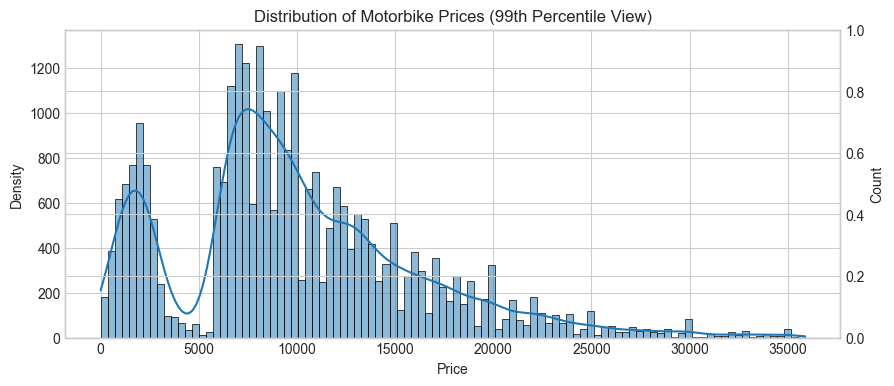

In [19]:
print("--- Generating Price Distribution Plot by Filtering ---")
price_limit = motor_bike['price'].quantile(0.99)
print(f"Plotting prices below the 99th percentile: {price_limit:.2f}")
filtered_data = motor_bike[motor_bike['price'] < price_limit]

plt.figure(figsize=(10, 4))
ax = sns.histplot(data=filtered_data, x='price', kde=True, bins=100)
ax2 = ax.twinx()

ax.set_title('Distribution of Motorbike Prices (99th Percentile View)')
ax.set_xlabel('Price')
ax.set_ylabel('Density')
ax2.set_ylabel('Count')
plt.show()

## Feature Engineering 🎯:

### 💰 Price Segment Feature

We introduced a new column **`price_segment`** to group motorbikes into markets:

* **Floor Market (< 5000)**: Low-priced motorbikes 🚲
* **Budget Market (5000+)**: Higher value motorbikes 🏍️

This helps us compare models and performance across different market levels.



<Figure size 640x480 with 0 Axes>

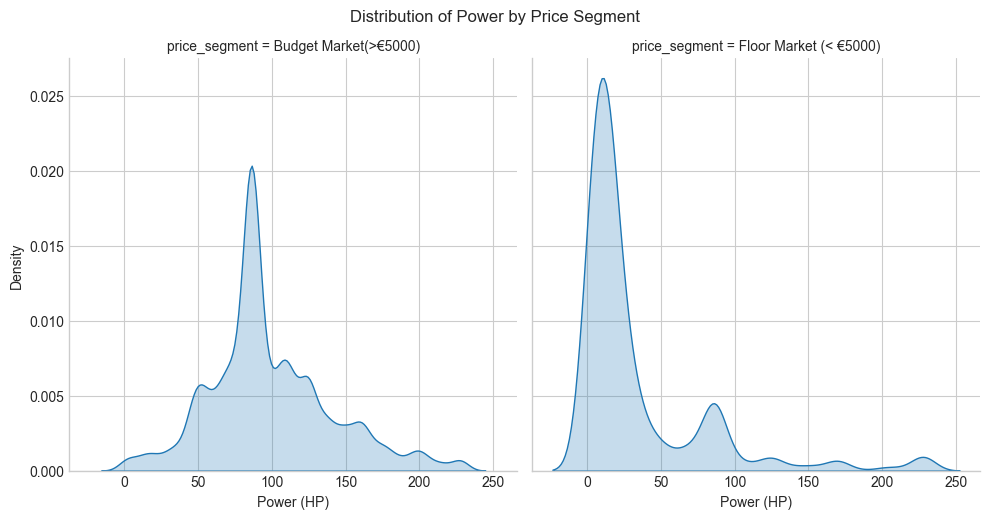

In [20]:
# --- 1. Create the Price Segment Feature ---
# We create the new column based on the price cutoff of 5,000
motor_bike['price_segment'] = np.where(
    motor_bike['price'] < 5000,  # Changed from price_segment to price
    'Floor Market (< €5000)',
    'Budget Market(>€5000)'
)

# --- 2. Visualize to Compare the Segments ---
# Plotting Power Distribution by Segment
plt.figure()
g = sns.displot(motor_bike, x="power_capped", col="price_segment", kind="kde", fill=True, common_norm=False)
g.fig.suptitle('Distribution of Power by Price Segment', y=1.03)
g.set_axis_labels("Power (HP)", "Density")
plt.show()

<Figure size 640x480 with 0 Axes>

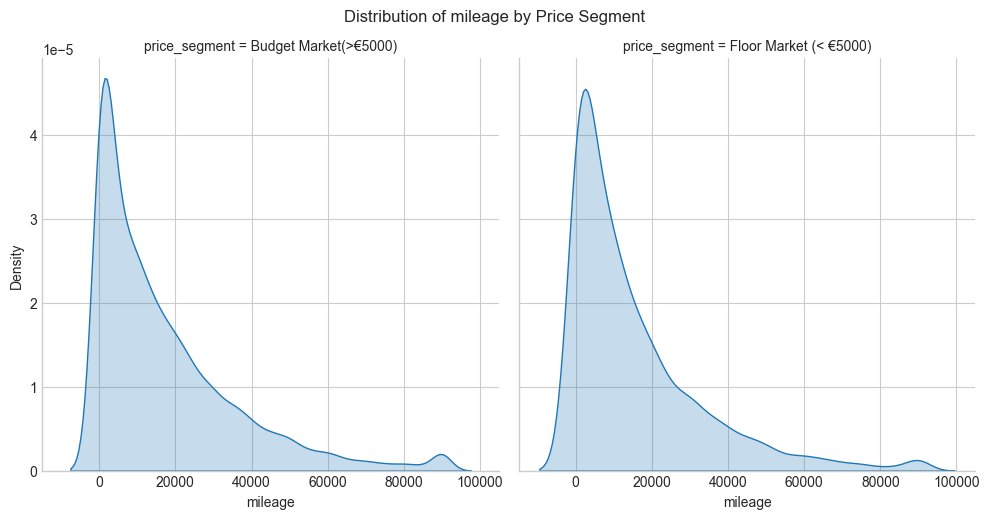

In [21]:
plt.figure()
g = sns.displot(motor_bike, x="mileage_capped", col="price_segment", kind="kde", fill=True, common_norm=False)
g.fig.suptitle('Distribution of mileage by Price Segment', y=1.03)
g.set_axis_labels("mileage", "Density")
plt.show()

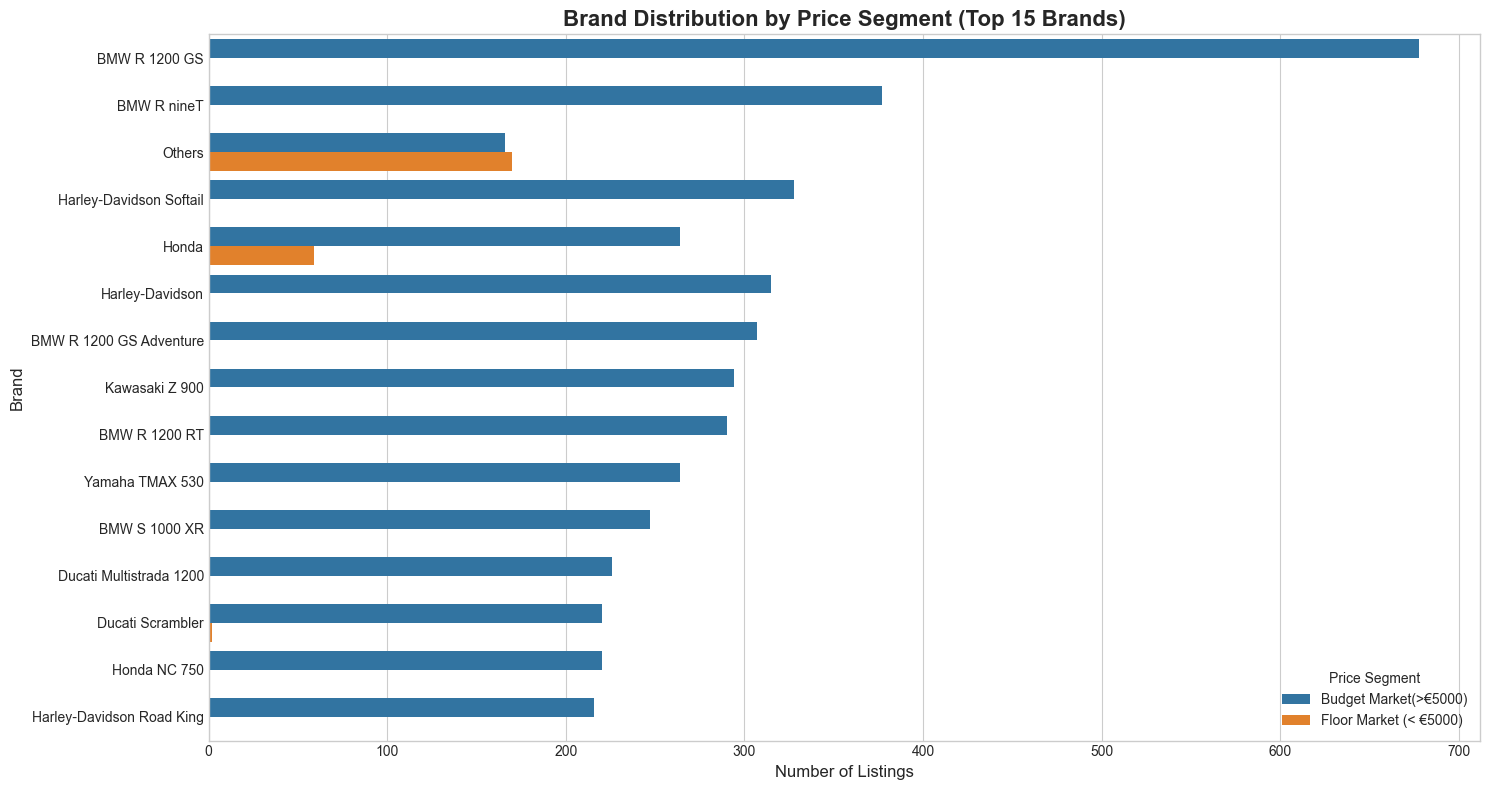

In [22]:
top_brands=motor_bike['make_model'].value_counts().nlargest(15).index
bikes_top_brands=motor_bike[motor_bike['make_model'].isin(top_brands)]
plt.figure(figsize=(15, 8))
sns.countplot(data=bikes_top_brands, y='make_model', hue='price_segment', order=top_brands)

plt.title('Brand Distribution by Price Segment (Top 15 Brands)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Listings', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.legend(title='Price Segment')
plt.tight_layout()
plt.show()

C:\Users\RAM MOHAN\AppData\Local\Temp\ipykernel_28860\3602131448.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_floor_brands.values, y=top_floor_brands.index, palette='plasma')


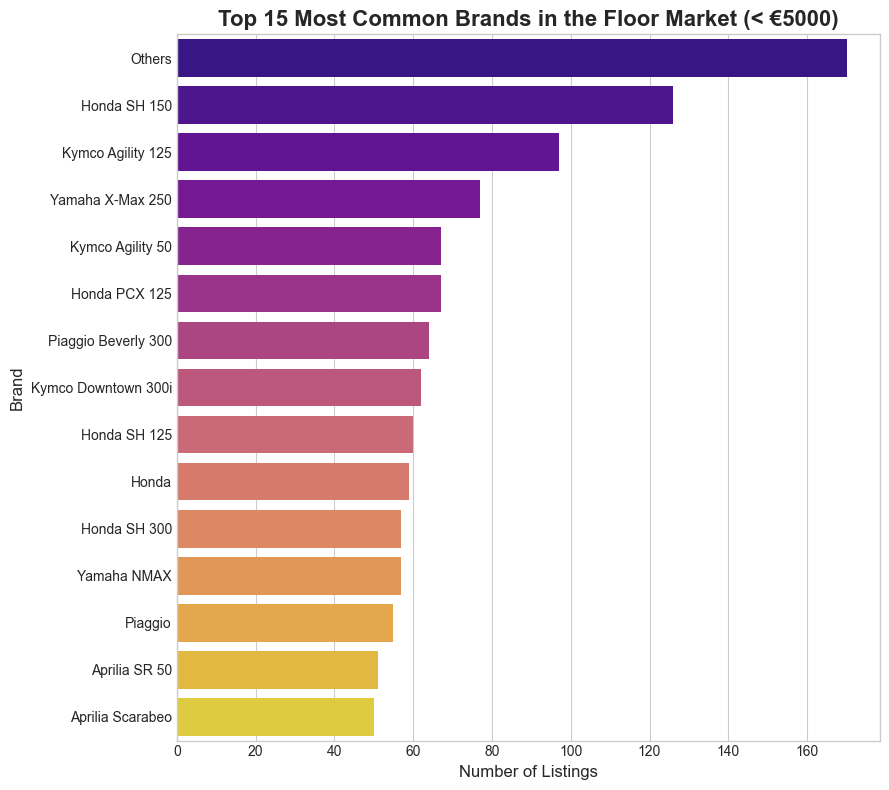

In [23]:
# --- Step 1: Filter for ONLY the 'Floor Market' bikes ---
floor_market_bikes = motor_bike[motor_bike['price_segment'] == 'Floor Market (< €5000)'].copy()

# --- Step 2: Find the top 15 brands within that filtered data ---
top_floor_brands = floor_market_bikes['make_model'].value_counts().nlargest(15)

# --- Step 3: Create the plot ---
plt.figure(figsize=(9, 8))
sns.barplot(x=top_floor_brands.values, y=top_floor_brands.index, palette='plasma')

plt.title('Top 15 Most Common Brands in the Floor Market (< €5000)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Listings', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.tight_layout()
plt.show()

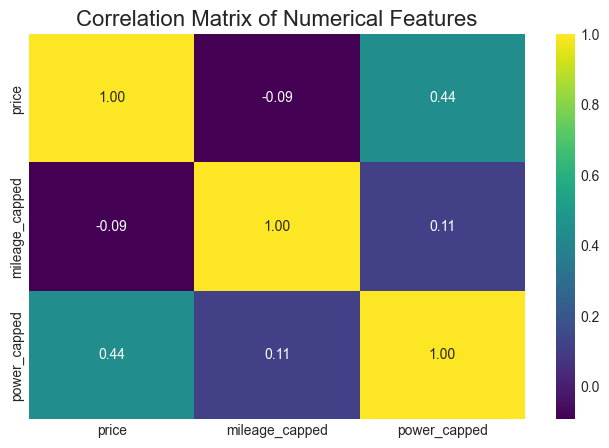

In [24]:
num_features=['price','mileage_capped','power_capped']
price_limit = motor_bike['price'].quantile(0.99)
filtered_data = motor_bike[motor_bike['price'] < price_limit]
correlation_matrix=filtered_data[num_features].corr()
plt.figure(figsize=(8,5))
sns.heatmap(correlation_matrix,annot=True,cmap='viridis',fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

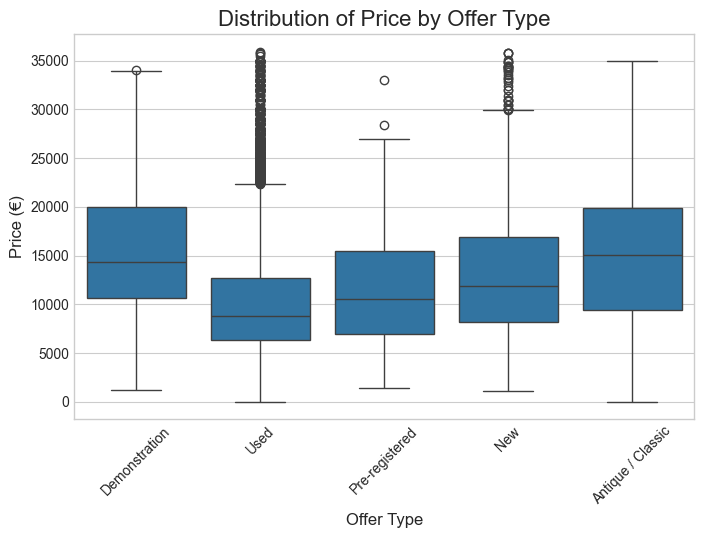

In [25]:


plt.figure(figsize=(8,5))
sns.boxplot(data=filtered_data,x='offer_type',y='price')
plt.title('Distribution of Price by Offer Type', fontsize=16)
plt.xlabel('Offer Type', fontsize=12)
plt.ylabel('Price (€)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


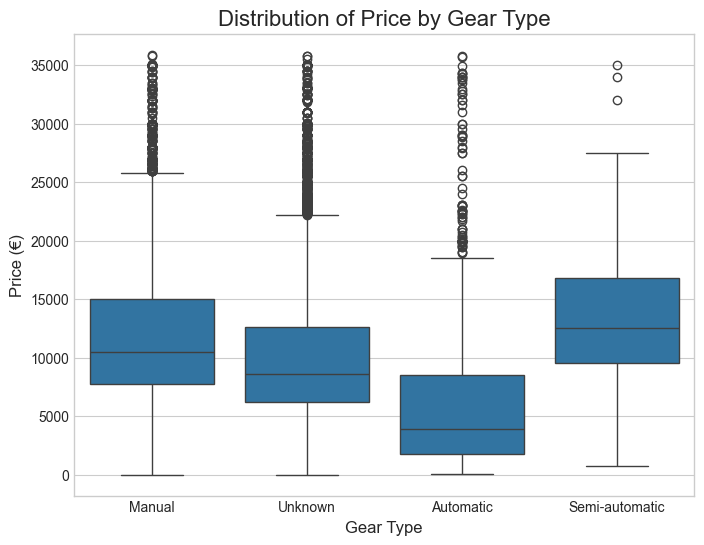

In [26]:
plt.figure(figsize=(8,6))
sns.boxplot(data=filtered_data,x='gear',y='price')
plt.title('Distribution of Price by Gear Type', fontsize=16)
plt.xlabel('Gear Type', fontsize=12)
plt.ylabel('Price (€)', fontsize=12)
plt.show()

In [27]:
# Calculate the 99th percentile for the price to use as a cap
price_cap = motor_bike['price'].quantile(0.99)

# Create a new DataFrame that excludes the extreme price outliers
motor_bike_filtered = motor_bike[motor_bike['price'] < price_cap].copy()

print(f"Original data shape: {motor_bike.shape}")
print(f"Shape after filtering price outliers: {motor_bike_filtered.shape}")

Original data shape: (29085, 13)
Shape after filtering price outliers: (28794, 13)


## Model Building 🏗️

In this step, we built and trained multiple regression models to predict **motorbike prices**. The chosen models were:

* **Random Forest Regressor** 🌲: An ensemble model that builds multiple decision trees and combines their results for robust predictions.
* **Gradient Boosting Regressor** 📉: A boosting method that builds trees sequentially, where each new tree corrects the errors of the previous one.
* **CatBoost Regressor** 🐱: A gradient boosting model optimized for categorical features, known for its efficiency and accuracy.

These models were trained on the processed dataset to compare their performance and select the best-performing one for price prediction.


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Stage 1: Final Feature Preparation (Revised Encoding) ---

# 1. Feature Engineering: Extract the Brand
motor_bike_filtered['brand'] = motor_bike['make_model'].apply(lambda x: x.split(' ')[0])

# 2. Log Transform the Target Variable (price)
motor_bike_filtered['price_log'] = np.log1p(motor_bike['price'])

# 3. Select Final Features and Target
features = [
    'mileage_capped',
    'power_capped',
    'brand',
    'fuel',
    'gear',
    'offer_type'
]
target = 'price_log'

X = motor_bike_filtered[features]
y = motor_bike_filtered[target]

# 4. Apply One-Hot Encoding to all categorical features
X_encoded = pd.get_dummies(X, columns=['brand', 'fuel', 'gear', 'offer_type'], drop_first=True)


# --- Stage 2: Building Your First Model ---

# 1. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 2. Train and Evaluate the Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions and convert back from log scale
y_pred_log = rf_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# Evaluate the model
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Model Performance on the Test Set:")
print(f"Mean Absolute Error (MAE): €{mae:,.2f}")
print(f"R-squared (R²): {r2:.2%}")

Model Performance on the Test Set:
Mean Absolute Error (MAE): €2,473.91
R-squared (R²): 59.84%
